In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-06-27 11:30:55.555633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_csv("../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter='\t')
gene_list_passed_qc = gene_dict_df.query("qc_pass").dependency_column.tolist()

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list_passed_qc, axis=1)
subset_test_df = test_df.filter(gene_list_passed_qc, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(912, 50)


,ModelID,0,1,2,3,4,5,6,7,8,...,39,40,41,42,43,44,45,46,47,48
0,ACH-001549,0.770663,-0.549157,3.272427,0.566686,-1.486665,0.159869,0.889582,1.580837,-0.117225,...,2.973020,1.915184,0.493111,1.111523,0.263324,0.769710,-0.086101,-0.768794,1.303094,0.310755
1,ACH-001992,0.096374,-0.050365,-0.552537,0.625854,0.279700,-0.311163,-0.501299,2.403682,0.620375,...,0.627633,0.346812,2.978342,-1.294521,0.783208,-0.074196,0.490011,-0.272740,-1.356594,0.506748
2,ACH-000035,1.288901,-0.706702,-1.537785,0.517040,-0.802465,0.035317,0.081034,1.719658,-0.696001,...,0.149666,1.048845,0.525381,1.301356,0.189475,1.039298,0.597261,-1.701137,-0.131737,1.178167
3,ACH-000911,-0.070980,0.314865,0.934309,0.493366,0.102961,0.122502,-0.826303,-0.109411,-0.845789,...,0.794017,0.286747,-1.250848,-0.015384,-0.600473,1.774455,-0.279023,-0.427222,-1.043919,-1.519211
4,ACH-000259,-0.955361,0.210109,0.473668,-0.839982,1.161763,-0.378171,-0.923595,1.949374,-0.167187,...,-1.157029,0.383896,0.609474,0.535174,-0.208617,-0.833482,1.100798,-0.020259,0.006875,-0.557194


In [8]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list_passed_qc, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001549,Adult,Male,train
1,ACH-001992,Adult,Male,train
2,ACH-000035,Adult,Male,train
3,ACH-000911,Adult,Male,train
4,ACH-000259,Pediatric,Female,train
...,...,...,...,...
907,ACH-000858,Adult,Male,test
908,ACH-000514,Adult,Male,test
909,ACH-000258,Adult,Female,test
910,ACH-002446,Adult,Male,test


In [9]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_or_test")

/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


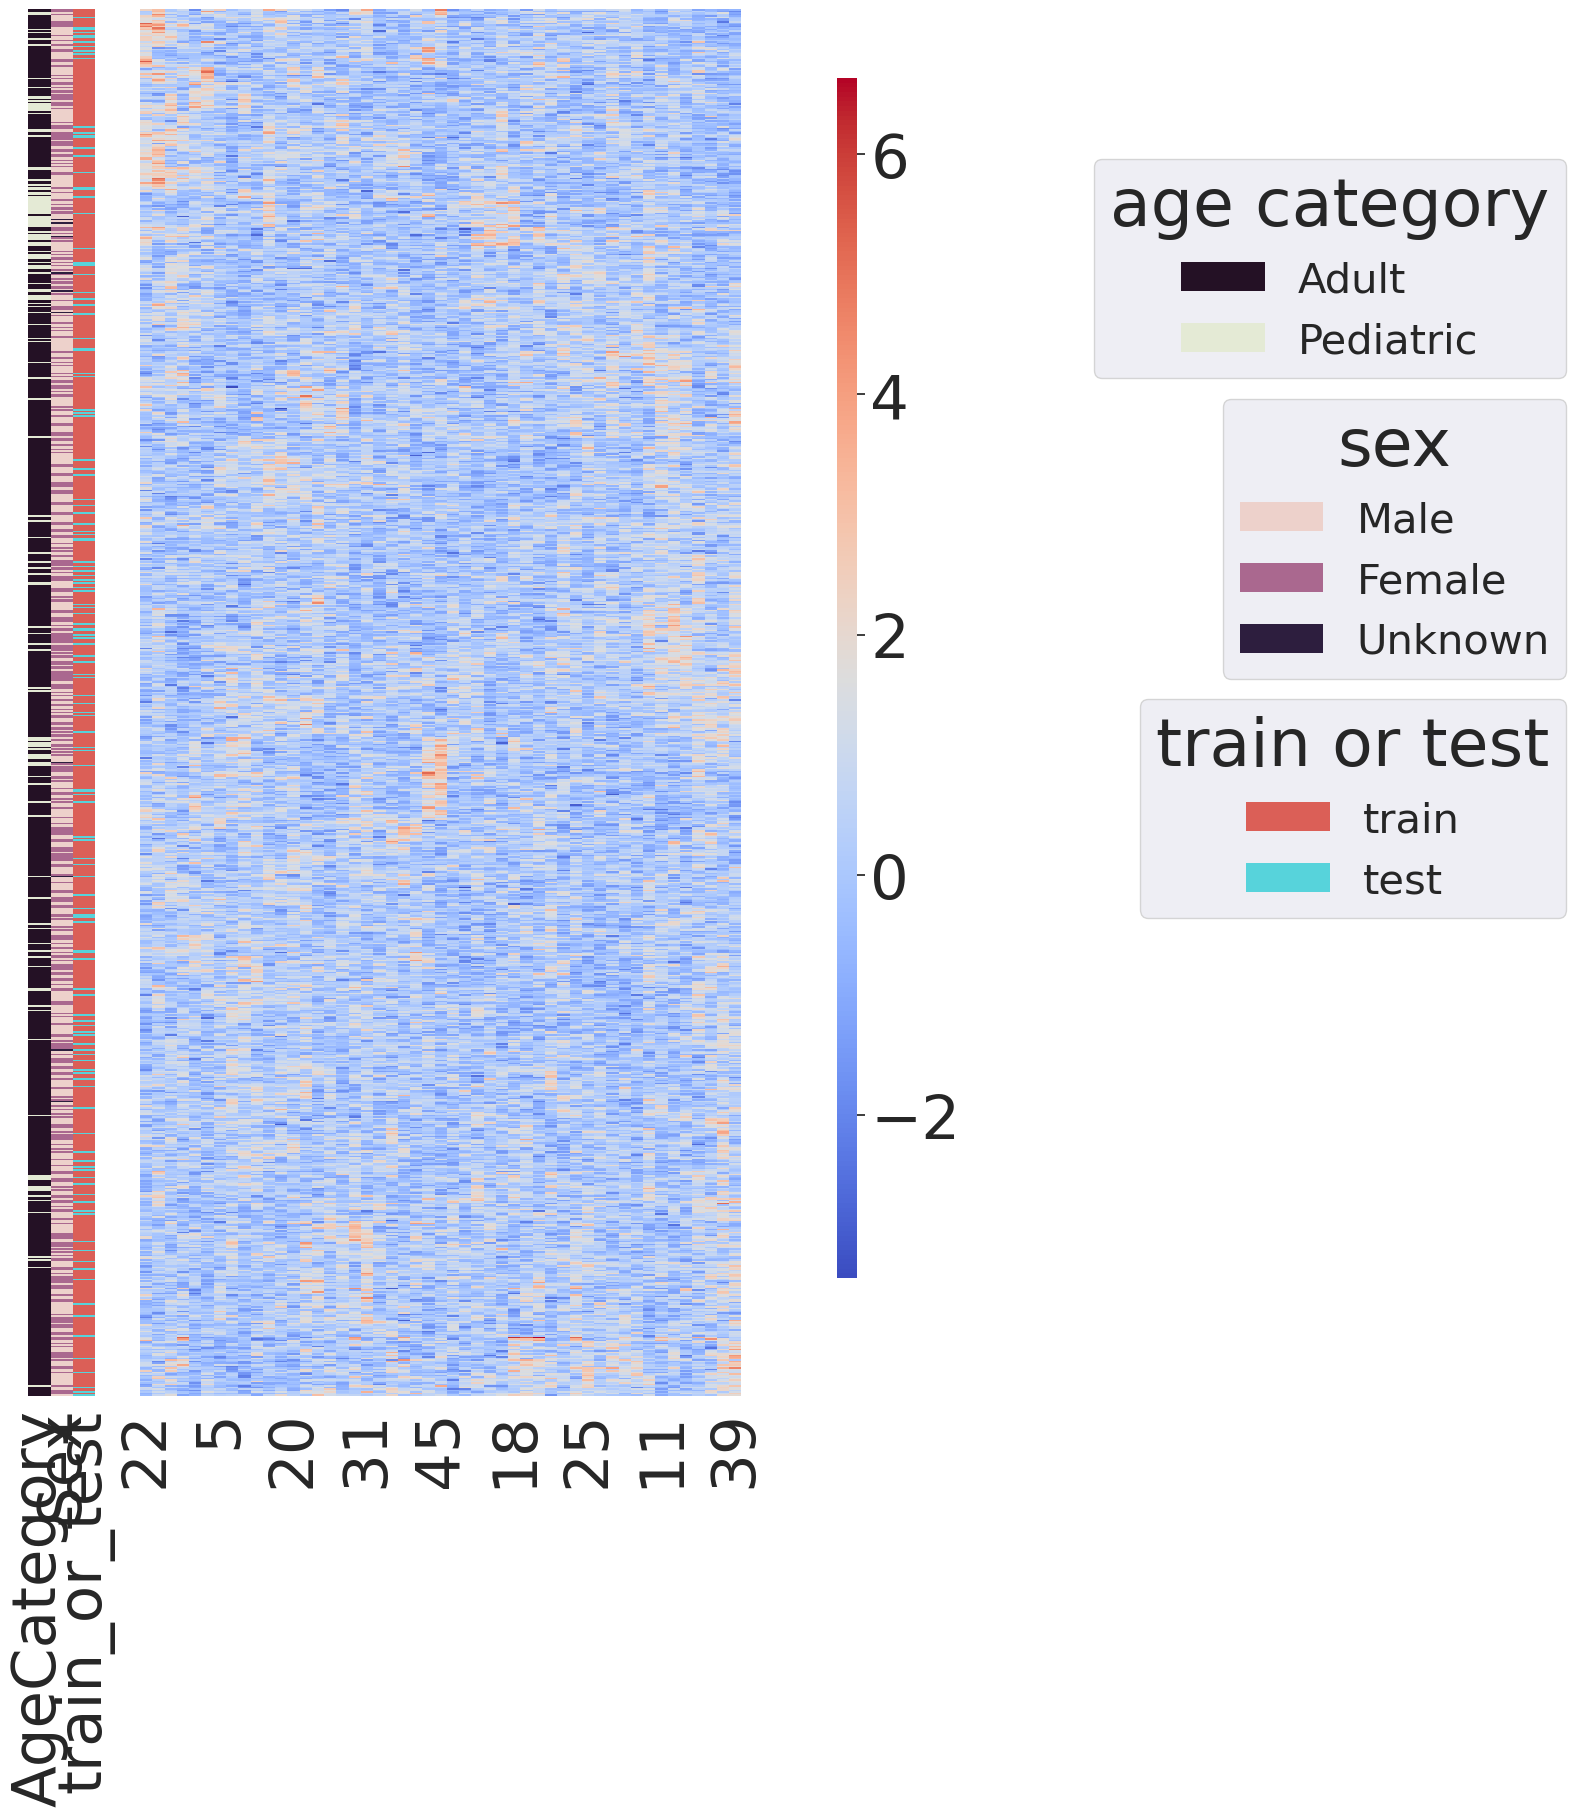

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train or test",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,-0.065762,-0.072253,0.047671,0.031671,0.099662,0.021346,0.065610,0.015976,0.035161,0.089890,...,-0.042195,0.013708,-0.099784,-0.084774,-0.037435,0.040306,0.020068,0.052680,0.046233,-0.010818
1,0.028984,-0.100351,0.015861,-0.041949,-0.070342,0.017694,-0.023452,0.054382,0.059402,-0.032064,...,0.026907,-0.022829,0.007821,0.028343,-0.053292,-0.011265,-0.035440,0.036614,-0.044030,-0.006800
2,0.045330,-0.053818,0.010939,-0.000805,-0.039995,0.021862,0.076901,-0.063818,-0.064618,-0.005598,...,-0.019090,-0.054465,-0.036813,-0.022718,-0.070924,0.020863,0.021782,-0.044477,-0.013088,-0.012784
3,-0.045774,0.007612,-0.011942,-0.046910,-0.053462,0.008274,-0.024193,-0.020667,-0.044887,0.003439,...,0.073001,0.001621,0.030357,-0.032754,0.058778,-0.000040,0.089375,0.011618,0.060612,-0.019115
4,0.008627,-0.056030,-0.037565,0.022606,-0.011073,-0.043281,-0.008081,-0.025632,-0.042584,-0.015704,...,-0.079438,-0.066371,0.027453,0.034278,0.135766,0.023697,0.035598,-0.086139,0.094295,-0.030740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,0.020960,0.013769,-0.090919,0.035909,-0.015389,0.095038,0.055137,0.040413,0.038495,-0.028815,...,-0.019712,-0.013973,-0.002060,0.005618,0.016834,0.017443,-0.023154,0.014303,0.017863,-0.034177
2728,-0.042790,0.052915,-0.065021,-0.060585,0.018433,-0.090084,0.044751,-0.047632,-0.097279,-0.030721,...,-0.107929,0.076432,0.004108,-0.016125,-0.033067,0.043343,-0.026774,-0.001842,0.010689,-0.083749
2729,-0.015497,-0.035867,-0.044702,-0.070030,-0.063550,-0.006556,-0.059233,-0.014506,-0.034322,0.022856,...,-0.007515,0.006092,-0.069778,-0.053767,0.035339,0.022818,0.032708,0.047347,-0.022125,-0.010686
2730,-0.035895,-0.088025,-0.026283,-0.084165,-0.024134,-0.098936,-0.047877,0.039265,0.037221,0.012885,...,0.018518,-0.031400,-0.033038,-0.000324,-0.012277,0.005548,0.019004,-0.030421,-0.029929,-0.041920


/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


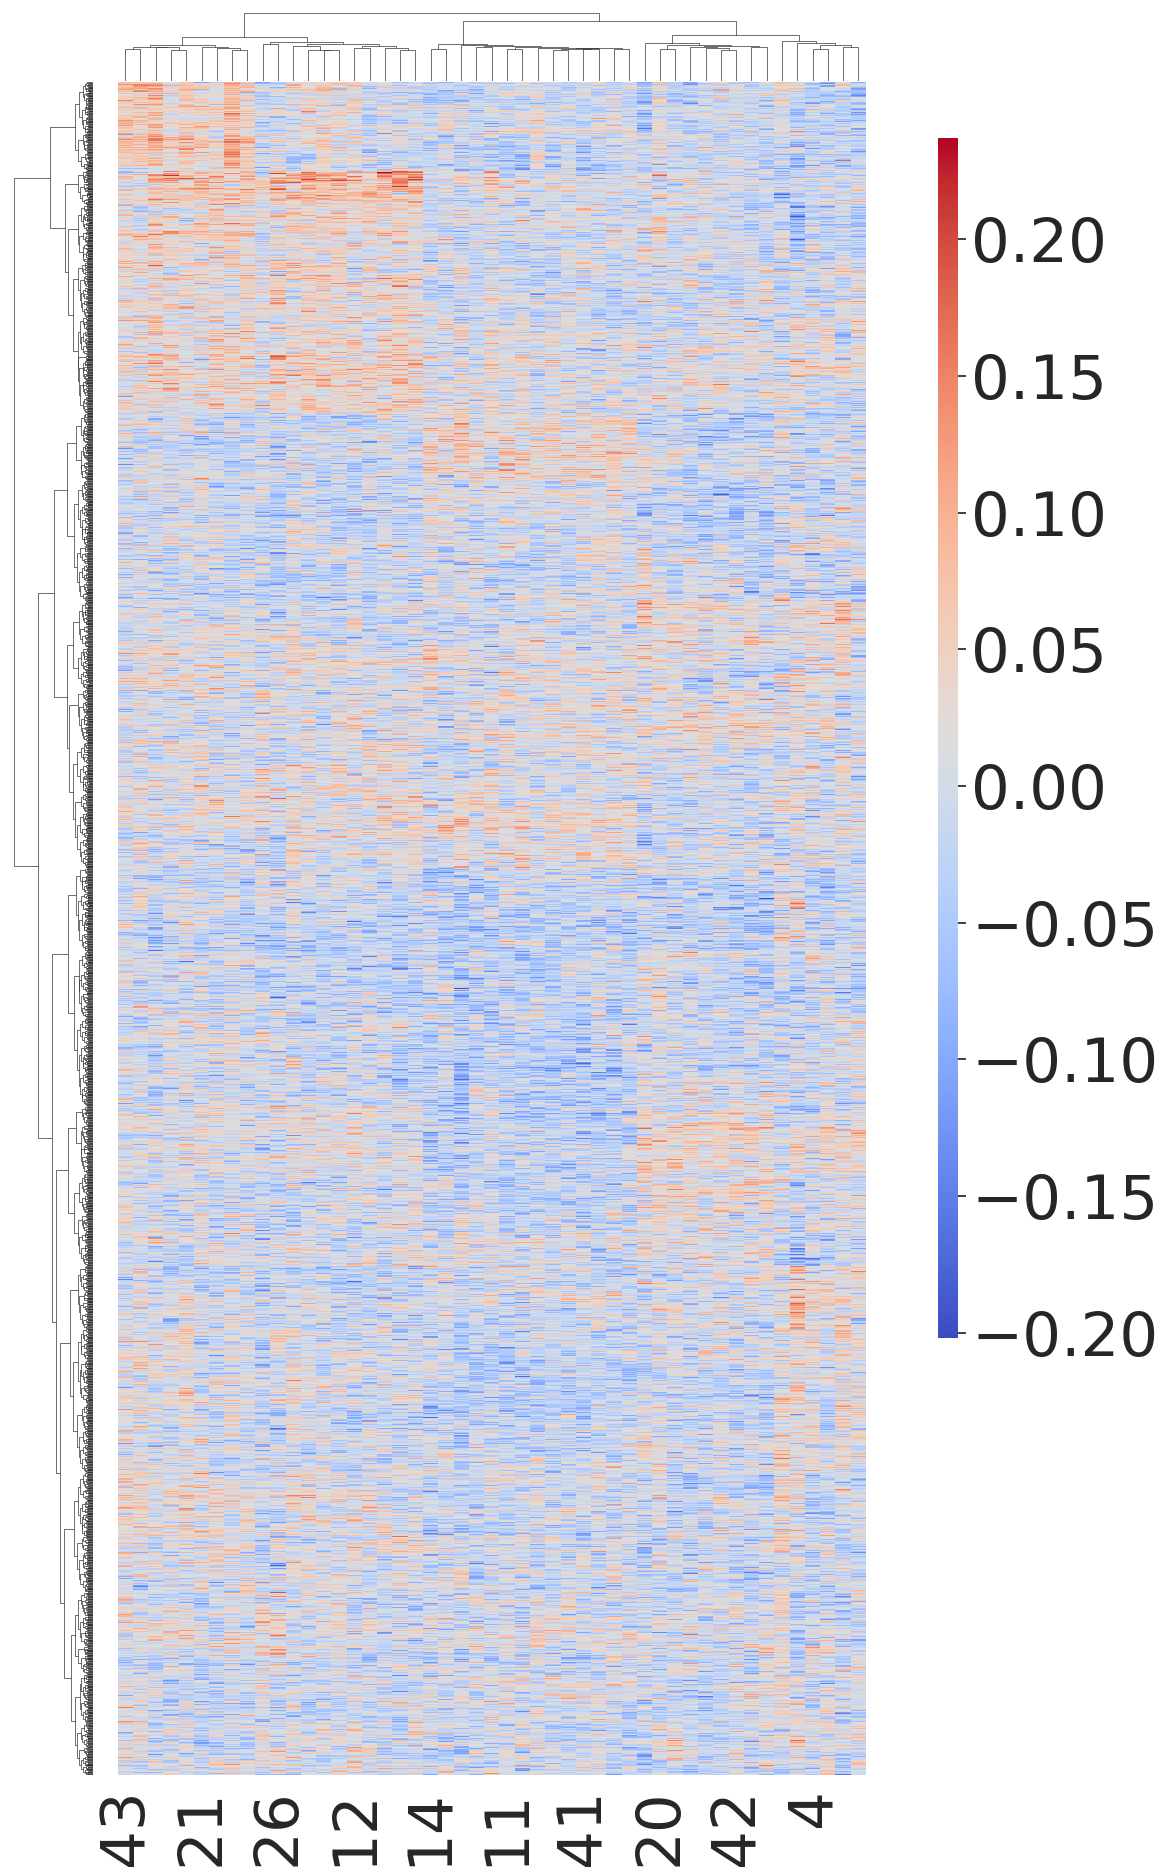

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
